In [ ]:
# !pip install wandb

In [ ]:
!wandb login 28fce819fb0b34ced149e8d6575ef8caf3dbdd2c

In [34]:
import torch
from torch.optim import Optimizer
from torch.nn import Parameter

from tqdm.notebook import tqdm
from typing import Iterator


# import sys
# sys.path.insert(1, "/kaggle/input/causal-mechanisms")

In [35]:
import sys
sys.path.insert(1, "/kaggle/input/causal-mechanisms")

from model import *
from transformer import *
from dataset import *
from model import *
from optim import *
from trainer import *
from utils import *
from selector import *
from metrics import *

# directory for checkpoints
checkpt_dir = './checkpoints'
create_checkpoints_dir(checkpt_dir)

In [36]:
# settings
seed = 23435

num_experts = 4
input_size = 32 * 32

# initialization hyper-parameters
load_initialized_experts = False
expert_model_name = 'mnist_expert'


# discriminator hyper-parameters
discriminator_optimizer = 'adam'
discriminator_learning_rate = .001
discriminator_weight_decay = 0

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# training hyper-parameters
expert_optimizer = 'adam'
expert_learning_rate = .001
expert_weight_decay = 0

epochs = 15

In [37]:
chains = make_chains(candidates=all_transformers, of_sizes={1}, avoid_repetition=True, identity_detector=None)
chain_names = [chain.name for chain in chains]
chain_names

['shift_up(x)',
 'shift_down(x)',
 'shift_right(x)',
 'shift_left(x)',
 'shift_up_left(x)',
 'shift_up_right(x)',
 'shift_down_left(x)',
 'shift_down_right(x)']

In [38]:
# load dataset
train_loader, test_loader, train_dataset, test_dataset = load_datasets(seed=seed, data_dir="./data", chains=chains, batch_size=64)

In [39]:
# Losses
loss_training = torch.nn.L1Loss(reduction='none')
loss_discriminator = torch.nn.BCELoss(reduction='mean')

In [40]:
# train experts as approximately identity on transformed data
# initialize experts

experts = init_identity_experts(num_experts, checkpt_dir, expert_model_name, load_initialized_experts, device, train_loader)

In [41]:
# setup discriminator
discriminator = MnistDiscriminator().to(device)
discriminator.optimizer = create_optimizer(discriminator.parameters(), discriminator_optimizer, lr=discriminator_learning_rate, wd=discriminator_weight_decay)

torch.Size([1, 32, 32])
32


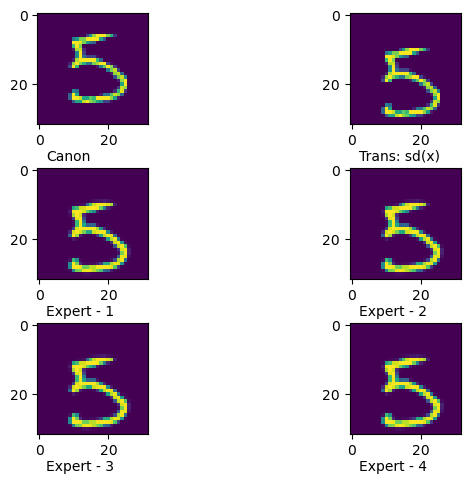

In [42]:
show_expert_demo(experts, test_dataset, 15, chains[1], device)

In [43]:
compositions = create_all_compositions(all_experts=experts, of_sizes={1, 2}, avoid_repetition=True)
comp_names = [c.name for c in compositions]
comp_names

['e1(x)',
 'e2(x)',
 'e3(x)',
 'e4(x)',
 'e2(e1(x))',
 'e1(e2(x))',
 'e3(e1(x))',
 'e1(e3(x))',
 'e4(e1(x))',
 'e1(e4(x))',
 'e3(e2(x))',
 'e2(e3(x))',
 'e4(e2(x))',
 'e2(e4(x))',
 'e4(e3(x))',
 'e3(e4(x))']

In [44]:
for expert in experts:
  expert.optimizer = create_optimizer(expert.parameters(), expert_optimizer, lr=expert_learning_rate, wd=expert_weight_decay)

In [45]:
import wandb
run_name = "clicm_2"

wandb.init(
    project="licm-research",
    name=run_name,
    config={
      "seed": seed,
      "num_experts": num_experts,
      "num_compositions": len(compositions),
      "chains": chain_names,
      "compositions": comp_names,
      "input_size": input_size,
      "load_initialized_experts": load_initialized_experts,
      "expert_model_name": expert_model_name,
      "discriminator_optimizer": discriminator_optimizer,
      "discriminator_learning_rate": discriminator_learning_rate,
      "discriminator_weight_decay": discriminator_weight_decay,
      "device": device,
      "expert_optimizer": expert_optimizer,
      "expert_learning_rate": expert_learning_rate,
      "expert_weight_decay": expert_weight_decay,
    }
)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

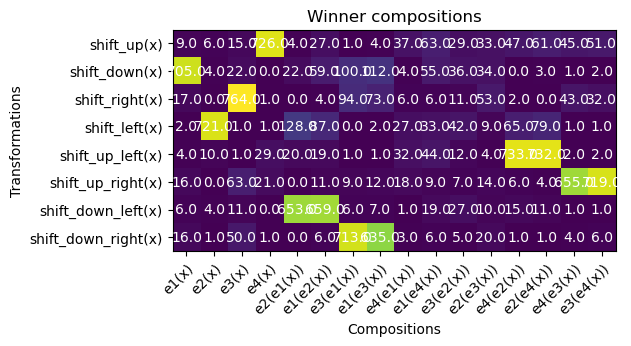

  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
# selector = GreedySelector(device, loss_training)
metrics = Metrics(comp_names, chain_names)

train_compositions_without_selector(
  epochs=epochs,
  input_size=input_size,
  criterion=loss_discriminator,
  device=device,
  discriminator=discriminator,
  experts=experts,
  compositions=compositions,
  data_train=train_loader,
  metrics=metrics
)

In [ ]:
for expert_index, expert in enumerate(experts):
#     torch.save(expert.state_dict(), checkpt_dir + f"/expert_{expert_index + 1}_trained.pth")
# torch.save(metrics, checkpt_dir + f"/metrics_trained.pth")
  artifact = wandb.Artifact(f"expert_{expert_index}", type="model")
  wandb.log_artifact(artifact)

In [ ]:
for i in tqdm(range(100)):
  show_compound(test_dataset, i, chains, compositions, device, num_experts)

In [ ]:
wandb.finish()